## **Exploratory Analysis**

I have investigated the features of the recipes dataset to understand which factors influence high traffic on our website. After analyzing the data, I identified key insights and applied the following transformations to better enable predictive modeling:

**Calories** : Applied a logarithmic transformation due to its skewed distribution.

**Category** : Grouped similar categories to improve clarity and reduce complexity.

**Target Variable - High Traffic**

Since we aim to predict whether a recipe leads to high traffic, our target variable is high_traffic (High/Low). The histogram of calories (left chart) showed a strong skewness toward lower values, indicating most recipes have fewer calories with occasional outliers. To address this, a log transformation was applied (right chart), resulting in a distribution that closely resembles normality, enhancing the effectiveness of further predictive modeling.

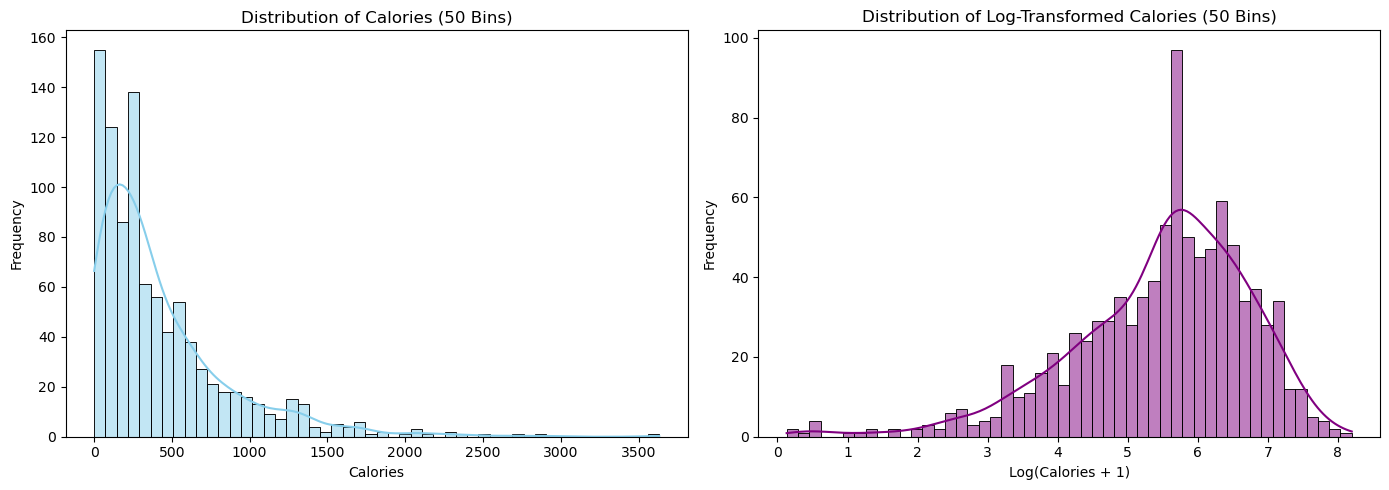

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

recipe_data = pd.read_csv("../data/processed/cleaned_recipes.csv")


plt.figure(figsize=(14,5))  # Wider figure for two side-by-side plots

# 1 Histogram of Raw Calories 
plt.subplot(1,2,1)
sns.histplot(recipe_data['calories'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Calories (50 Bins)")
plt.xlabel("Calories")
plt.ylabel("Frequency")

# 2 Histogram of Log-Transformed Calories 
plt.subplot(1,2,2)
# Adding 1 to avoid log(0) if there are zero values
log_calories = np.log(recipe_data['calories'] + 1)
sns.histplot(log_calories, bins=50, kde=True, color='purple')
plt.title("Distribution of Log-Transformed Calories (50 Bins)")
plt.xlabel("Log(Calories + 1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Categorical Variable - Recipe Category**

I examined the distribution of recipes across different categories to identify popular recipe types. From the bar chart below, we clearly see Chicken recipes dominate the dataset as the most frequent category, followed by Breakfast and Beverages. In contrast, One Dish Meal is the least represented category. This insight highlights the potential of prioritizing Chicken and Breakfast recipes for homepage placement, considering their popularity and abundance in the dataset.

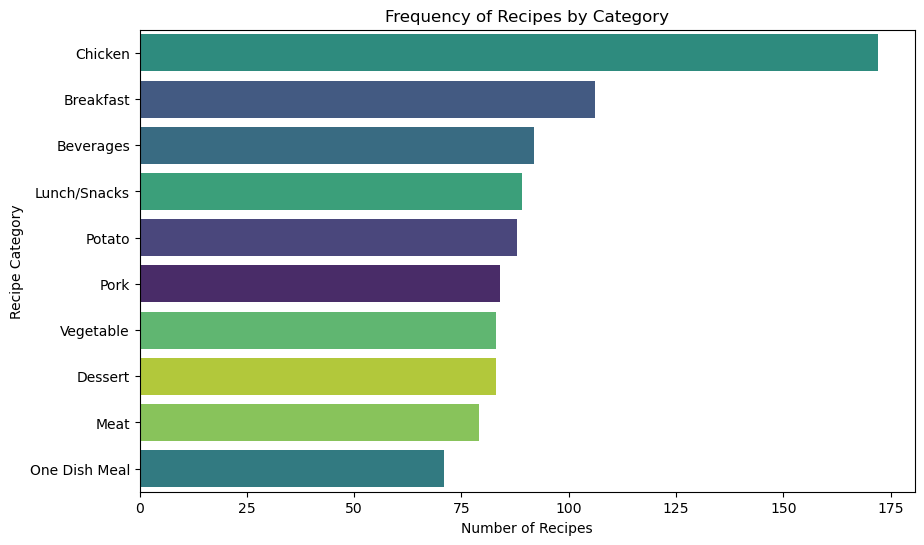

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Recipe Categories
plt.figure(figsize=(10,6))

sns.countplot(
    data=recipe_data,
    y='category',
    order=recipe_data['category'].value_counts().index,
    hue='category',
    palette='viridis',
    legend=False
)

plt.title("Frequency of Recipes by Category")
plt.xlabel("Number of Recipes")
plt.ylabel("Recipe Category")
plt.show()


From the heatmap below, we can conclude there is a weak positive correlation between calories and protein, while other nutritional variables show very low correlations with each other. This suggests these variables can individually contribute meaningful insights when predicting high-traffic recipes.

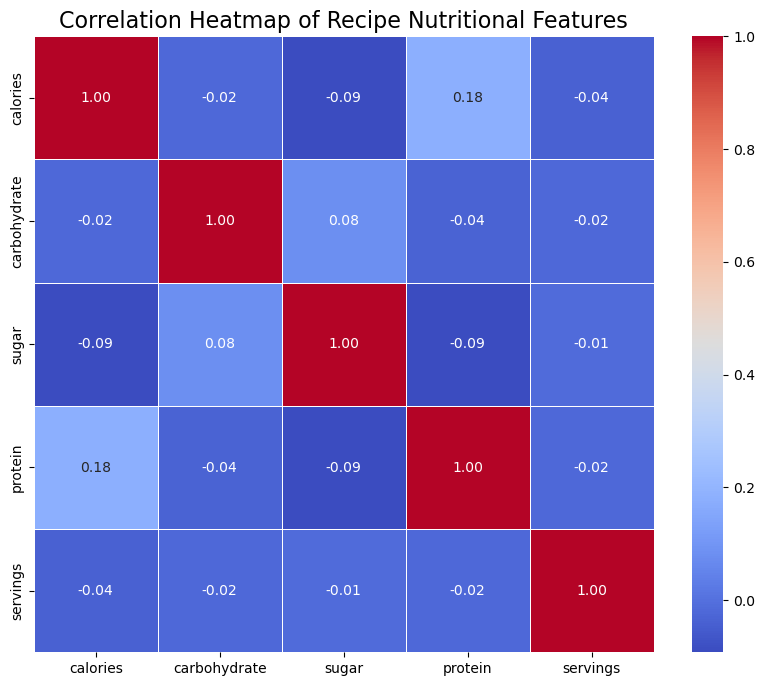

In [29]:
plt.figure(figsize=(10, 8))

# Select only meaningful numeric columns for the analysis
numeric_features = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']

sns.heatmap(recipe_data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap of Recipe Nutritional Features', fontsize=16)
plt.show()

Nutritional attributes show weak, non-linear relationships with recipe traffic and significant overlap between high- and low-traffic recipes, indicating that popularity is driven by broader contextual factors rather than nutrition alone.

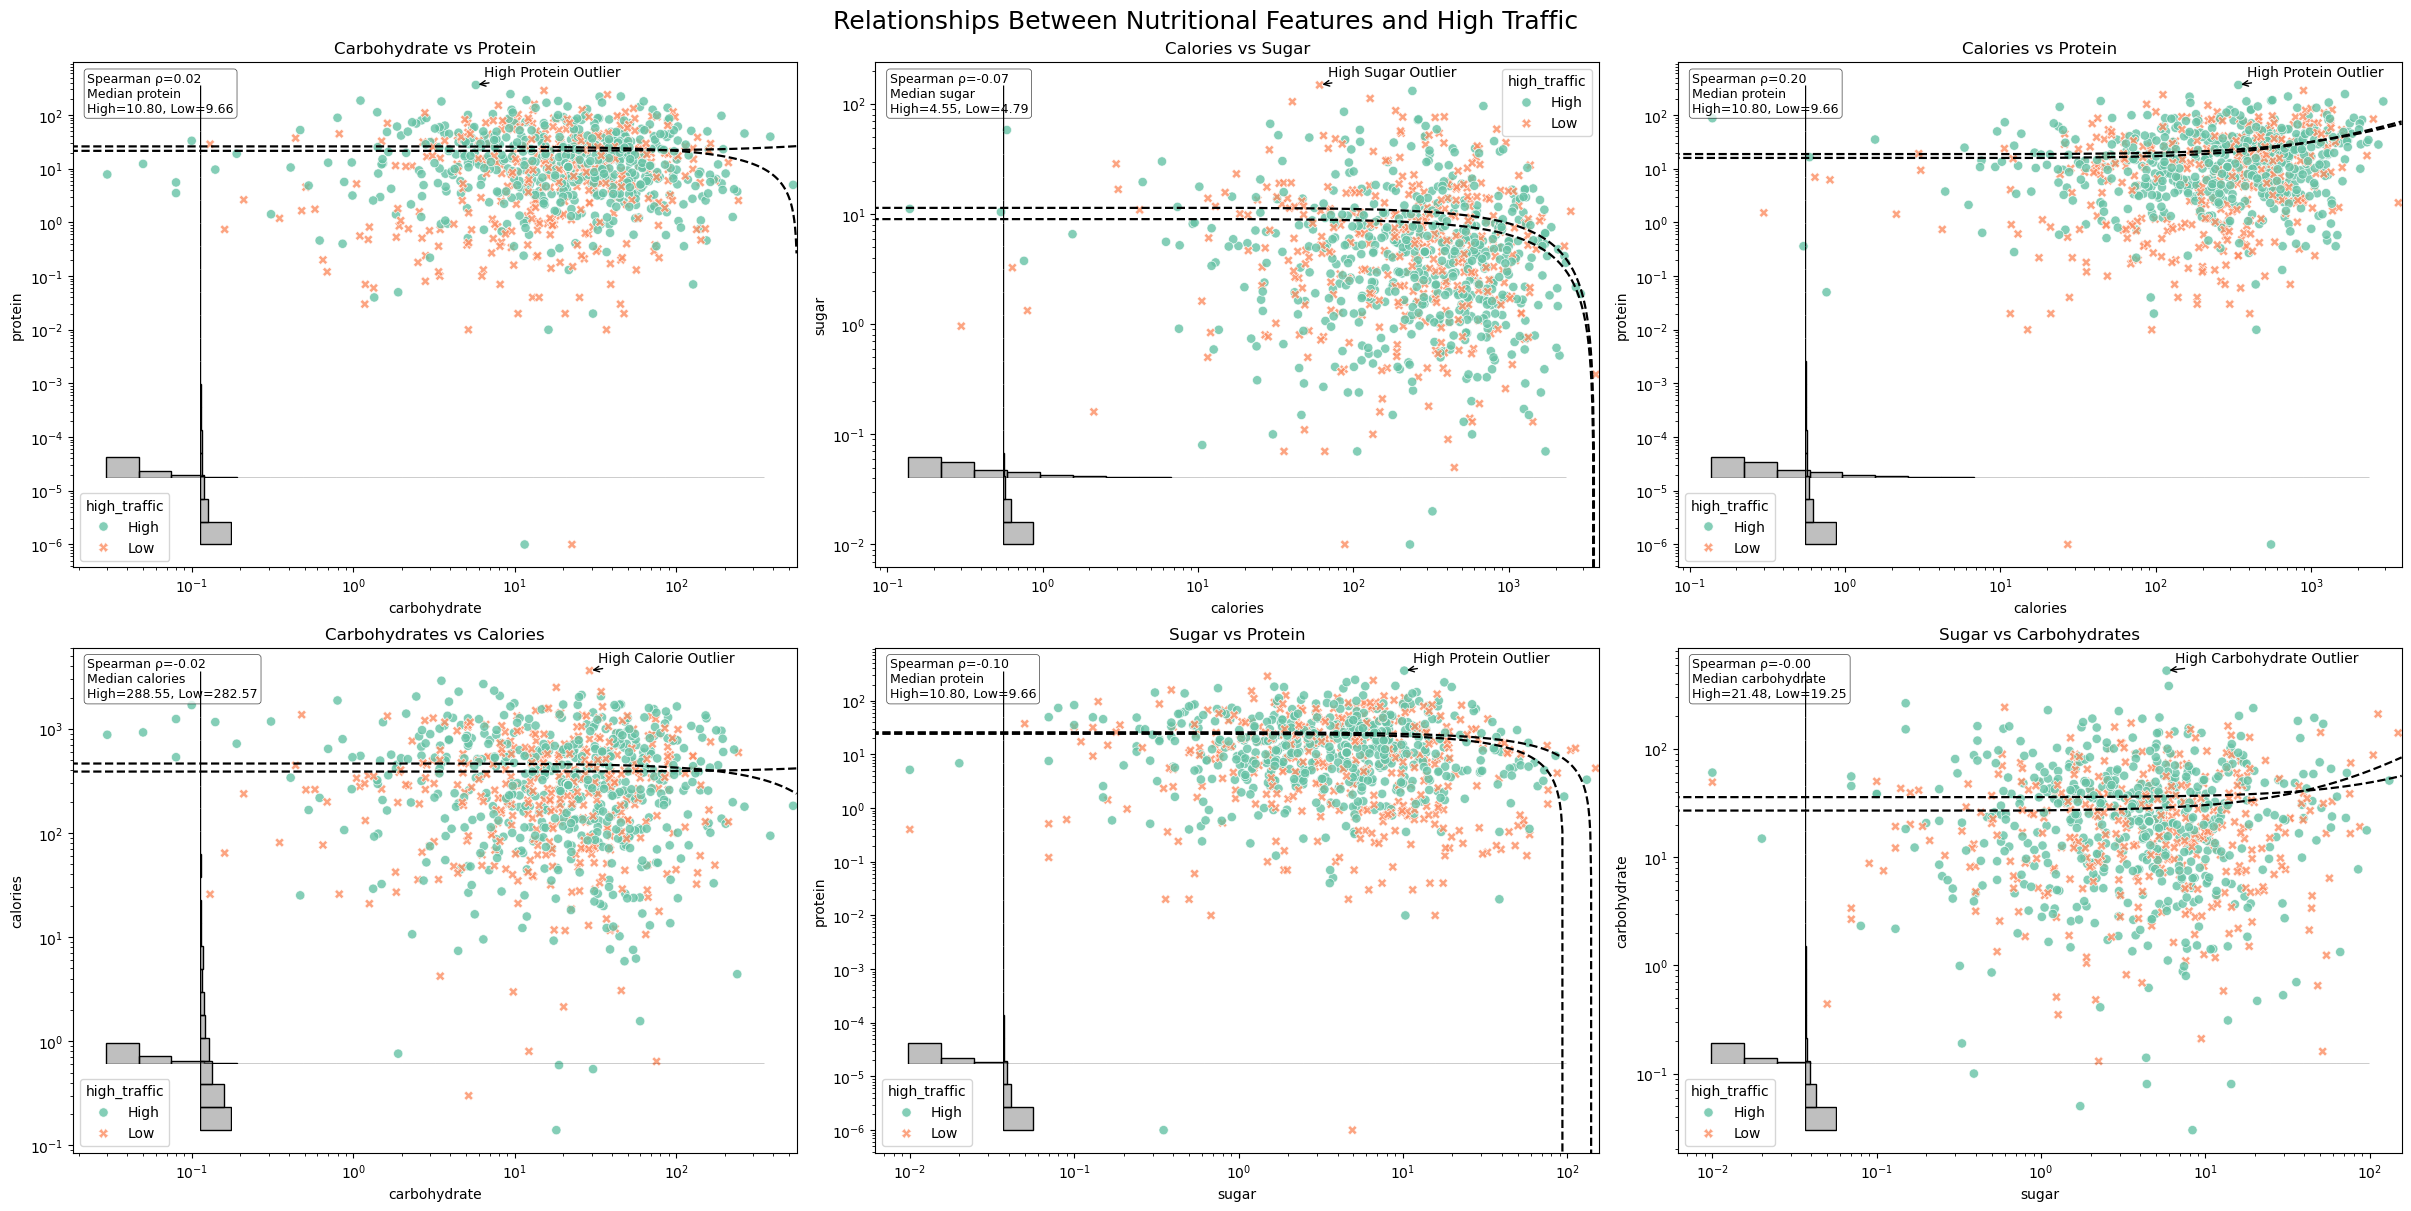

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -----------------------------
# 0) Prep data
# -----------------------------
cols_for_plots = ["calories", "carbohydrate", "protein", "sugar"]
target_col = "high_traffic"  # binary target variable
EPS = 1e-6

# Drop rows with missing values in relevant columns
plot_data = recipe_data.dropna(subset=cols_for_plots + [target_col]).copy()

# clip values to avoid log(0)
for c in cols_for_plots:
    plot_data[c] = plot_data[c].clip(lower=EPS)

# map target variable to "high" and "low" 
if plot_data[target_col].dtype != "O":
    plot_data[target_col] = plot_data[target_col].map({1: "High", 0: "Low", True: "High", False: "Low"}).fillna(plot_data[target_col])

# -----------------------------
# 1) inset marginal histograms
# -----------------------------
def add_marginal_histograms(ax, data, x, y):
    
    ax_histx = inset_axes(
        ax, width="100%", height="20%", loc="upper center",
        bbox_to_anchor=(0, 0, 1, 0.22), bbox_transform=ax.transAxes, borderpad=0
    )
    sns.histplot(data=data, x=x, ax=ax_histx, bins=20, color="gray", alpha=0.5)
    ax_histx.set_axis_off()

    
    ax_histy = inset_axes(
        ax, width="20%", height="100%", loc="upper right",
        bbox_to_anchor=(0, 0, 0.22, 1), bbox_transform=ax.transAxes, borderpad=0
    )
    sns.histplot(data=data, y=y, ax=ax_histy, bins=20, color="gray", alpha=0.5)
    ax_histy.set_axis_off()

# -----------------------------
# 2) plotting function for each panel
# -----------------------------
def plot_panel(ax, data, x, y, title, outlier_label=None, outlier_on="y"):
     
    sns.scatterplot(
        ax=ax, data=data, x=x, y=y,
        hue=target_col, style=target_col,
        palette="Set2", s=45, alpha=0.8
    )

    
    for cls, ls in [("High", "--"), ("Low", "--")]:
        sub = data[data[target_col] == cls]
        if len(sub) >= 5:
            sns.regplot(
                ax=ax, data=sub, x=x, y=y,
                scatter=False, ci=None, truncate=False,
                color="black", line_kws={"linestyle": ls, "linewidth": 1.6}
            )

     
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title)

    # Marginals 
    add_marginal_histograms(ax, data, x, y)

    # Panel stats (quantitative insight)
    rho = data[[x, y]].corr(method="spearman").iloc[0, 1]

    # Median comparison by class
    med_high_y = data.loc[data[target_col] == "High", y].median()
    med_low_y  = data.loc[data[target_col] == "Low",  y].median()

    ax.text(
        0.02, 0.98,
        f"Spearman ρ={rho:.2f}\nMedian {y}\nHigh={med_high_y:.2f}, Low={med_low_y:.2f}",
        transform=ax.transAxes, va="top", ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.75, linewidth=0.5)
    )

    # Outlier annotation
    if outlier_label:
        try:
            col = y if outlier_on == "y" else x
            row = data.loc[data[col].idxmax()]
            ax.annotate(
                outlier_label,
                (row[x], row[y]),
                textcoords="offset points", xytext=(6, 6),
                arrowprops=dict(arrowstyle="->", linewidth=1)
            )
        except Exception:
            pass

# -----------------------------
# 3) Build figure with 6 panels
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(24, 12), constrained_layout=True)
axes = axes.flatten()

plot_panel(
    axes[0], plot_data, "carbohydrate", "protein",
    "Carbohydrate vs Protein",
    outlier_label="High Protein Outlier", outlier_on="y"
)

plot_panel(
    axes[1], plot_data, "calories", "sugar",
    "Calories vs Sugar",
    outlier_label="High Sugar Outlier", outlier_on="y"
)

plot_panel(
    axes[2], plot_data, "calories", "protein",
    "Calories vs Protein",
    outlier_label="High Protein Outlier", outlier_on="y"
)

plot_panel(
    axes[3], plot_data, "carbohydrate", "calories",
    "Carbohydrates vs Calories",
    outlier_label="High Calorie Outlier", outlier_on="y"
)

plot_panel(
    axes[4], plot_data, "sugar", "protein",
    "Sugar vs Protein",
    outlier_label="High Protein Outlier", outlier_on="y"
)

plot_panel(
    axes[5], plot_data, "sugar", "carbohydrate",
    "Sugar vs Carbohydrates",
    outlier_label="High Carbohydrate Outlier", outlier_on="y"
)

fig.suptitle("Relationships Between Nutritional Features and High Traffic", fontsize=18)
plt.show()



**Calorie Distribution and Its Relationship with Recipe Popularity (Traffic)**

Analysis of calorie distributions shows that high-traffic and low-traffic recipes have very similar median calorie values, indicating that calories alone do not strongly distinguish popular recipes. While high-traffic recipes exhibit slightly greater variability and include some higher-calorie outliers, these extremes are not consistently associated with increased traffic. Overall, the substantial overlap between the two groups suggests that calorie content by itself is not a reliable predictor of recipe popularity. This motivates the inclusion of additional nutritional features and their interactions, as well as non-nutritional factors, to better explain and predict recipe traffic.

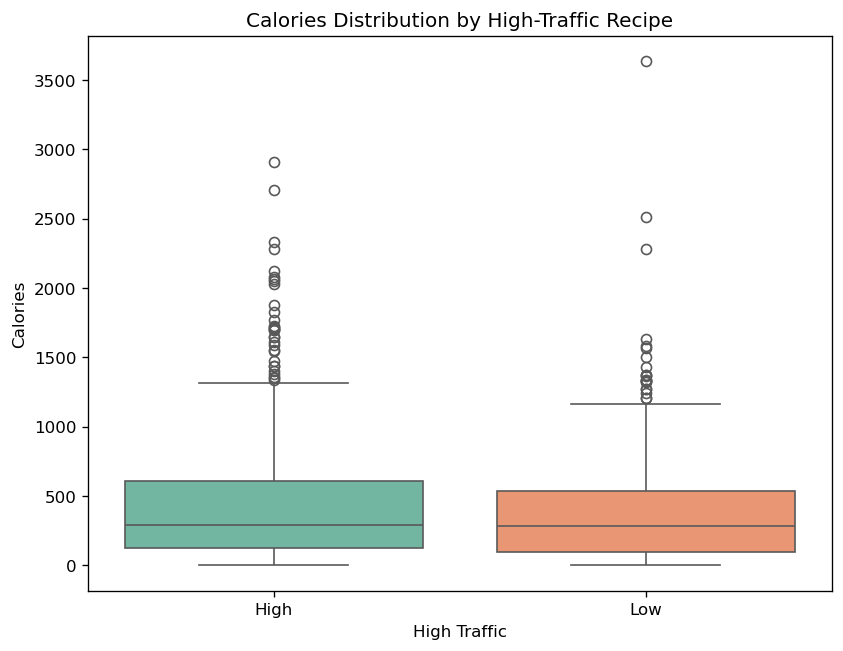

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6), dpi=120)
sns.boxplot(
    x='high_traffic',
    y='calories',
    hue='high_traffic',
    data=recipe_data,
    palette='Set2',
    legend=False
)
plt.title("Calories Distribution by High-Traffic Recipe")
plt.xlabel("High Traffic")
plt.ylabel("Calories")
plt.show()

**Calorie Distribution and Its Relationship with Recipe Popularity (Traffic)**

I've analyzed the relationship between calories and recipe popularity (traffic). The boxplot indicates that both high-traffic and low-traffic recipes have similar median calorie values, suggesting calories alone don't strongly differentiate popular recipes. However, high-traffic recipes show slightly greater variability and a higher range of outliers, indicating that recipes with unusually high calories can sometimes attract significant website traffic so I need to explore additional factors alongside calories to better predict recipe popularity.

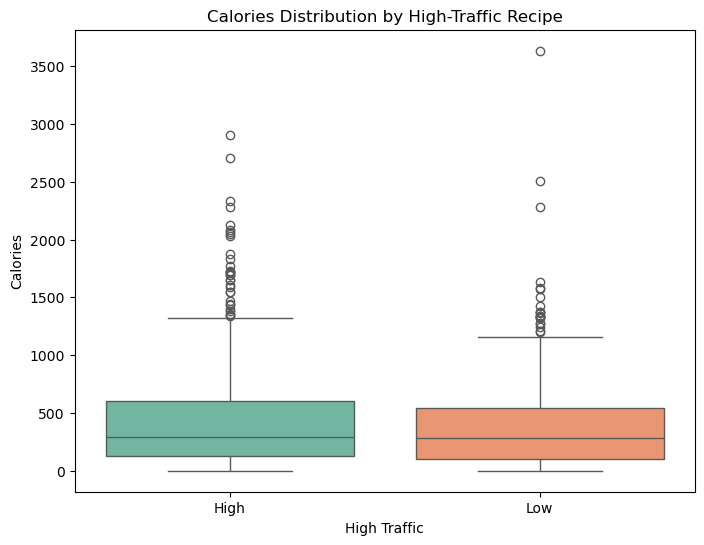

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.boxplot(
    x='high_traffic',
    y='calories',
    hue='high_traffic',
    data=recipe_data,
    palette='Set2',
    legend=False
)

plt.title("Calories Distribution by High-Traffic Recipe")
plt.xlabel("High Traffic")
plt.ylabel("Calories")
plt.show()

The violin plot also shows both high‐ and low‐traffic recipes center around 3–4 servings, though high‐traffic recipes show a slightly wider range (1 to 7 servings). This overlap indicates serving size alone likely isn’t a strong predictor of recipe traffic.

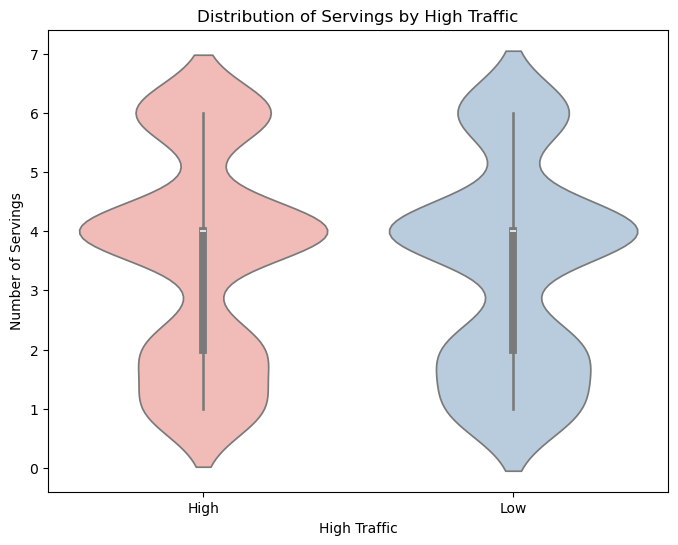

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.violinplot(
    x='high_traffic',
    y='servings',
    hue='high_traffic',
    data=recipe_data,
    palette='Pastel1',
    legend=False
)

plt.title("Distribution of Servings by High Traffic")
plt.xlabel("High Traffic")
plt.ylabel("Number of Servings")
plt.show()

**High vs. Low Traffic Recipes by Category**

Most categories lean toward low‐traffic recipes, but Breakfast and Dessert show notable high‐traffic shares. Beverages has the smallest proportion of high‐traffic recipes, suggesting potential for growth in that segment.

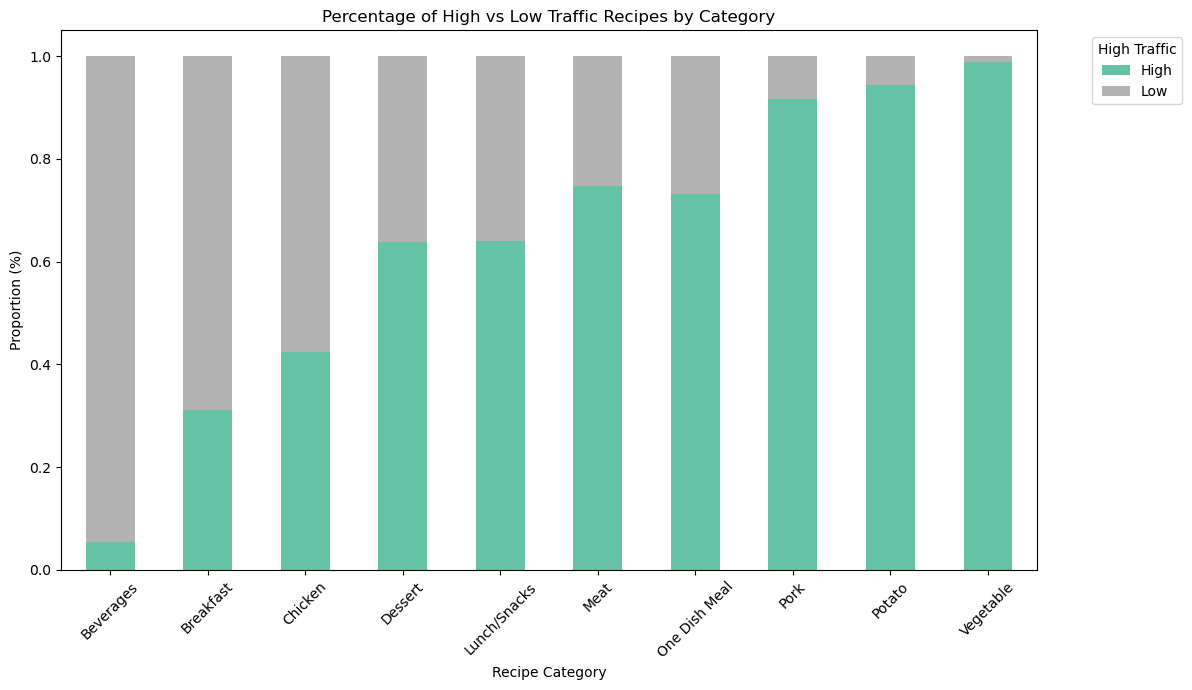

In [34]:
# Calculate normalized proportions
traffic_category_pct = (recipe_data
                        .groupby('category')['high_traffic']
                        .value_counts(normalize=True)
                        .unstack()
                        .fillna(0))

# Plot stacked bar chart
traffic_category_pct.plot(kind='bar', stacked=True, figsize=(12,7), colormap='Set2')

plt.title("Percentage of High vs Low Traffic Recipes by Category")
plt.xlabel("Recipe Category")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=45)
plt.legend(title='High Traffic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The results show that calories do not affect recipe popularity in the same way across all categories. In categories such as Pork and One Dish Meals, recipes with higher calorie counts often receive high traffic, suggesting that users expect these dishes to be filling or rich. In contrast, Breakfast and Beverages stay within lower calorie ranges regardless of traffic level, indicating that popularity in these categories is not strongly tied to calorie content.
This matters because it shows that users judge recipes within the context of their category rather than by calorie count alone. A high-calorie dinner recipe may be acceptable or expected, while a similarly high-calorie breakfast or drink would be unusual. For modeling, this means calorie features should be interpreted alongside recipe category rather than treated as a single global signal. For product decisions, it suggests that calorie-based filtering or promotion should be applied selectively by category instead of uniformly across all recipes.

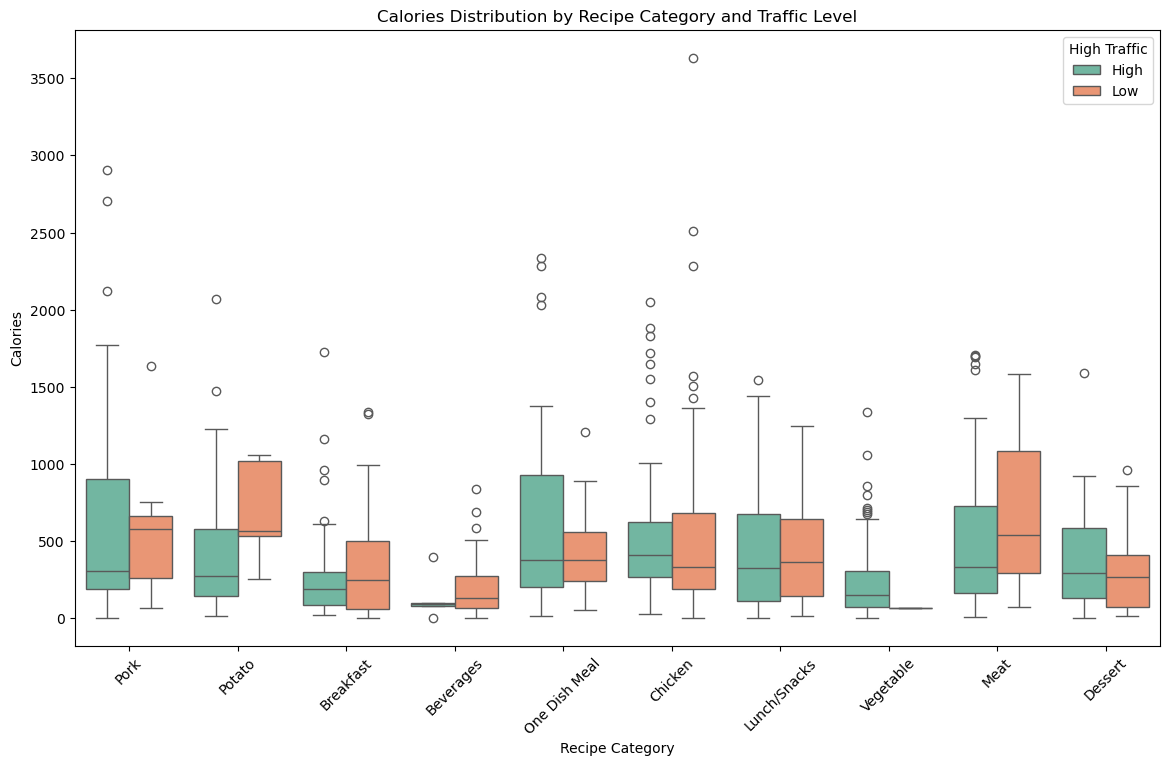

In [35]:
plt.figure(figsize=(14,8))
sns.boxplot(x='category', y='calories', hue='high_traffic', data=recipe_data, palette='Set2')
plt.title("Calories Distribution by Recipe Category and Traffic Level")
plt.xlabel("Recipe Category")
plt.ylabel("Calories")
plt.xticks(rotation=45)
plt.legend(title="High Traffic", loc="upper right")
plt.show()

Most categories share a similar servings range of 2–5, though Dessert shows a notably higher median for high‐traffic recipes.

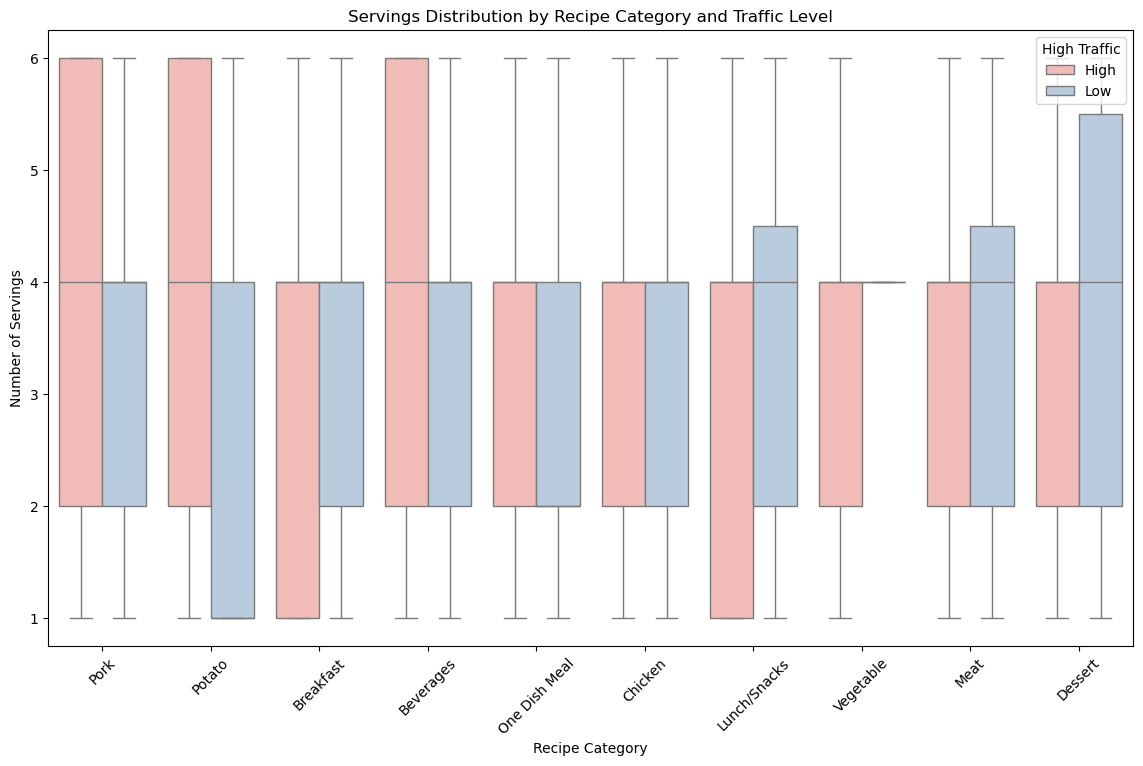

In [36]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='category', y='servings', hue='high_traffic', data=recipe_data, palette='Pastel1')
plt.title("Servings Distribution by Recipe Category and Traffic Level")
plt.xlabel("Recipe Category")
plt.ylabel("Number of Servings")
plt.xticks(rotation=45)
plt.legend(title="High Traffic", loc="upper right")
plt.show()

**Distribution of Categories by High Traffic**

Some categories, such as Chicken or One Dish Meal, draw higher traffic, indicating a possible link between category and recipe popularity. However, category alone may not guarantee popularity; further analysis is needed to confirm whether it’s a key driver of traffic.

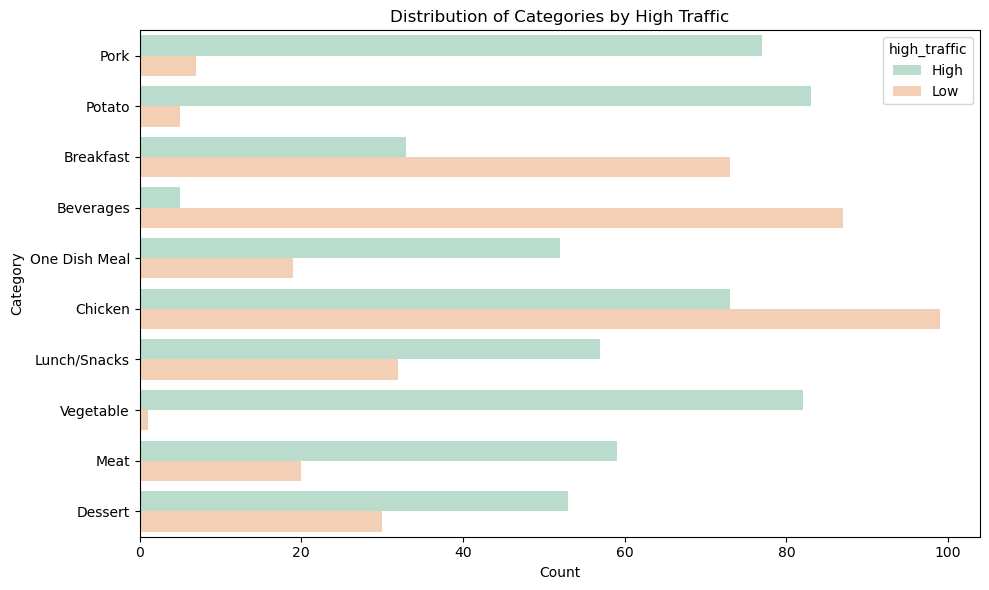

In [37]:
plt.figure(figsize=(10, 6))

# Countplot: Category distribution by high_traffic (the clearest insight)
sns.countplot(
    data=recipe_data, 
    y='category', 
    hue='high_traffic', 
    palette='Pastel2'
)
plt.title('Distribution of Categories by High Traffic')
plt.xlabel('Count')
plt.ylabel('Category')

plt.tight_layout()
plt.show()